<a href="https://colab.research.google.com/github/charlie2099/Shark-Image-Classifier-CNN/blob/main/Shark_Image_Classifier_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###**Creative Task:** An image classifier for identifying dangerous species of shark using a Convolutional Neural Network (CNN)
###**Application:** A detection system for identifying and detecting different species of sharks, alerting nearby divers of their presence.


###**Useful Sources:** Sources utilised to help learn about CNNs and how to construct them


####Source 1: https://classroom.udacity.com/courses/ud188

####Source 2: https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

####Source 3: https://colab.research.google.com/github/bentrevett/pytorch-image-classification/blob/master/1_mlp.ipynb

#Preparation

###Importing The Dataset

In [41]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [42]:
!unzip '/content/gdrive/MyDrive/shark_dataset_v3.zip' > /dev/null

###Import Libraries

In [3]:
import torch
from torch import nn, optim
import torch.nn.functional as F
import torch.optim as optim
import torch.nn as nn
import torchvision.models as models
from torchvision import datasets, transforms
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# check if CUDA is available, if so utilise GPU
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
  print('CUDA is not available. Training on CPU.')
else:
  print('CUDA is available. Training on GPU.')

CUDA is available. Training on GPU.


###Variable Adjustments

In [43]:
data_dir = 'shark_dataset_v3/shark_dataset' #dataset directory 
image_res = 32
image_crop = 224
rand_rot = 5
batch_size = 4 
mean_norm = [0.485, 0.456, 0.406]           #normalised mean
std_norm = [0.229, 0.224, 0.225]            #normalised standard deviation

###Transforms Setup (MLP and CNN)

In [44]:
# defining the transforms 
transform = transforms.Compose([transforms.Resize(image_res), 
                                transforms.CenterCrop(image_res), 
                                transforms.ToTensor(), # convert data to torch.FloatTensor
                                transforms.Normalize([0.5, 0.5, 0.5],
                                                     [0.5, 0.5, 0.5])]) # normalise with mean 0.5 and standard deviation 0.5 for each colour channel

# Training, Validation and Testing directorys
train_data = datasets.ImageFolder(data_dir + '/train', transform=transform)
val_data = datasets.ImageFolder(data_dir + '/val', transform=transform)
test_data = datasets.ImageFolder(data_dir + '/test', transform=transform)

# data loaders preparation
train_loader = torch.utils.data.DataLoader(train_data, batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size, shuffle=True)

###Transforms Setup (CNN With Pretrained Network)

In [5]:
# define transforms
# training (with random flips and rotation)
train_transform = transforms.Compose([transforms.Resize(236),
                                transforms.RandomRotation(5), 
                                transforms.CenterCrop(224),
                                transforms.RandomHorizontalFlip(),
                                transforms.ToTensor(),
                                transforms.Normalize(mean_norm, std_norm)])

# validation and testing
transform = transforms.Compose([transforms.Resize(224), 
                                transforms.CenterCrop(224), 
                                transforms.ToTensor(),
                                transforms.Normalize(mean_norm, std_norm)])

# Training, Validation and Testing directorys
train_data = datasets.ImageFolder(data_dir + '/train', transform=train_transform)
val_data = datasets.ImageFolder(data_dir + '/val', transform=transform)
test_data = datasets.ImageFolder(data_dir + '/test', transform=transform)

# data loaders preparation
train_loader = torch.utils.data.DataLoader(train_data, batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size, shuffle=True)

###Transforms Setup (t-SNE)

In [18]:
# define batch size
batch_size = 100

# define transforms
transform = transforms.Compose([transforms.Resize(224), # resize to 224x?
                                transforms.CenterCrop(224), # take a square (224x224) crop from the centre
                                transforms.ToTensor(), # convert data to torch.FloatTensor
                                transforms.Normalize([0.485, 0.456, 0.406],
                                                     [0.229, 0.224, 0.225])]) # normalise for each colour channel

# choose the test dataset
test_data = datasets.ImageFolder(data_dir + '/test', transform=transform)

# prepare the data loader
test_loader = torch.utils.data.DataLoader(test_data, batch_size, shuffle=True)

###Displaying Images Through imShow function (Note: Adjust parameters accordingly first)

In [45]:
def imshow(image, ax=None, title=None, normalize=True):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        #mean = np.array([0.5, 0.5, 0.5]) #MLP and #CNN
        #std = np.array([0.5, 0.5, 0.5]) 
        mean = np.array([0.485, 0.456, 0.406]) #CNN with Pretrained Network, t-SNE
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return ax

###Displaying An Initial Batch of Images

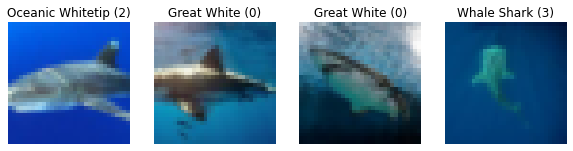

In [46]:
# obtain one batch of training images
data_iter = iter(train_loader)
images, labels = next(data_iter)

shark_list = ["Great White", "Leopard Shark", "Oceanic Whitetip", "Whale Shark"]

# first 4 images in the batch annotated with corresponding labels
fig, axes = plt.subplots(figsize=(10,4), ncols=4)
for i in range(4):
    ax = axes[i]
    imshow(images[i], ax=ax, normalize=True)

    if labels[i].item() == 0:
      ax.set_title(shark_list[0]+' ('+ str(labels[i].item())+')')   
    if labels[i].item() == 1:
      ax.set_title(shark_list[1]+' ('+ str(labels[i].item())+')') 
    if labels[i].item() == 2:
      ax.set_title(shark_list[2]+' ('+ str(labels[i].item())+')') 
    if labels[i].item() == 3:
      ax.set_title(shark_list[3]+' ('+ str(labels[i].item())+')') 

#Multi-layer Perceptron (MLP) Classifier (initially: 30%) (best: 52%)

###MLP Network Architecture Setup

In [47]:
# if using greyscale images, image size 28x28x1 = 784
# if using colour images, image size 28x28x3 = 2352
input_size = image_res * image_res * 3                                                              

class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        # number of hidden nodes in each layer
        hidden_1 = 1028
        hidden_2 = 512
        hidden_3 = 256
        numberOfClasses = 4
        # linear layers
        self.fc1 = nn.Linear(input_size, hidden_1)
        self.fc2 = nn.Linear(hidden_1, hidden_2)
        self.fc3 = nn.Linear(hidden_2, hidden_3)
        self.fc4 = nn.Linear(hidden_3, numberOfClasses) 
        # Dropout module with 0.2 drop probability - to prevent overfitting
        self.dropout = nn.Dropout(p=0.2)
        
    def forward(self, x):
        # make sure input tensor is flattened
        x = x.view(-1, input_size)
        # add hidden layers, with relu activation function, and dropout
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))
        # add output layer with logSoftmax
        x = F.log_softmax(self.fc4(x), dim=1) 
        return x

# initialise the neural network
model = MLP()
print(model)

MLP(
  (fc1): Linear(in_features=3072, out_features=1028, bias=True)
  (fc2): Linear(in_features=1028, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=256, bias=True)
  (fc4): Linear(in_features=256, out_features=4, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)


###Loss and Optimizer Initialisation

In [48]:
# specify the loss function (negative log likelihood loss)
criterion = nn.NLLLoss()
# specify the optimizer (Adam optimiser) and learning rate = 0.003
optimizer = optim.Adam(model.parameters(), lr=0.003)

###Training The Network

In [49]:
# number of epochs to train the model
n_epochs = 10

# initialise tracker for minimum validation loss
valid_loss_min = np.Inf # set initial "min" to infinity

# create empty lists to store the training and validation losses
train_losses, val_losses = [], []

for epoch in range(n_epochs):
    # monitor training loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train() # prep model for training
    for data, target in train_loader:
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item()*data.size(0)
        
    ######################    
    # validate the model #
    ######################
    model.eval() # prep model for evaluation
    for data, target in val_loader:
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update running validation loss 
        valid_loss += loss.item()*data.size(0)
        
    # print training/validation statistics 
    # calculate average loss over an epoch
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(val_loader.sampler)

    # store the training and validation losses for later visualisation
    train_losses.append(train_loss)
    val_losses.append(valid_loss)
    
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch+1, 
        train_loss,
        valid_loss
        ))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'MLP_model.pt') # save in colab
        torch.save(model.state_dict(), '/content/gdrive/MyDrive/MLP_model.pt') # save in google drive
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 1.994814 	Validation Loss: 1.434732
Validation loss decreased (inf --> 1.434732).  Saving model ...
Epoch: 2 	Training Loss: 1.392305 	Validation Loss: 1.415623
Validation loss decreased (1.434732 --> 1.415623).  Saving model ...
Epoch: 3 	Training Loss: 1.502290 	Validation Loss: 1.454468
Epoch: 4 	Training Loss: 1.517974 	Validation Loss: 1.937565
Epoch: 5 	Training Loss: 1.465609 	Validation Loss: 1.188374
Validation loss decreased (1.415623 --> 1.188374).  Saving model ...
Epoch: 6 	Training Loss: 1.519810 	Validation Loss: 1.239787
Epoch: 7 	Training Loss: 1.874767 	Validation Loss: 1.363620
Epoch: 8 	Training Loss: 1.574192 	Validation Loss: 1.258310
Epoch: 9 	Training Loss: 1.171595 	Validation Loss: 1.276612
Epoch: 10 	Training Loss: 1.399772 	Validation Loss: 1.251747


###Visualising The Results By Plotting Them To a Graph

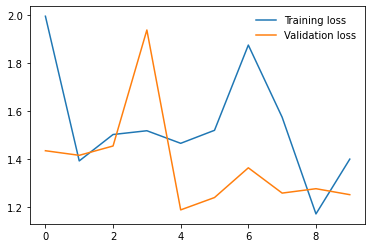

In [50]:
# Visualise the training and validation losses over time
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend(frameon=False)

In [51]:
# Load the Model with the Lowest Validation Loss
model.load_state_dict(torch.load('MLP_model.pt'))

<All keys matched successfully>

###Evaluating The Test Accuracy Results

In [52]:
# initialize lists to monitor test loss and accuracy
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval() # prep model for evaluation

for data, target in test_loader:
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    # compare predictions to true label
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))
    # calculate test accuracy for each object class
    for i in range(len(target)):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# calculate and print avg test loss
test_loss = test_loss/len(test_loader.sampler)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(4):
    if class_total[i] > 0:
        if i == 0:
          print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            "Great Whites     ", 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
        if i == 1:
          print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
              "Leopard Sharks   ", 100 * class_correct[i] / class_total[i],
              np.sum(class_correct[i]), np.sum(class_total[i])))
        if i == 2:
          print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
              "Oceanic Whitetips", 100 * class_correct[i] / class_total[i],
              np.sum(class_correct[i]), np.sum(class_total[i])))
        if i == 3:
          print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
              "Whale Sharks     ", 100 * class_correct[i] / class_total[i],
              np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 1.250847

Test Accuracy of Great Whites     : 16% ( 3/18)
Test Accuracy of Leopard Sharks   : 73% (11/15)
Test Accuracy of Oceanic Whitetips: 29% ( 5/17)
Test Accuracy of Whale Sharks     : 90% (18/20)

Test Accuracy (Overall): 52% (37/70)


###Visualising How Well The Network Performed

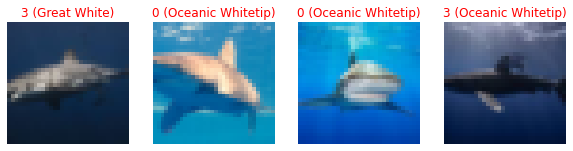

In [53]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds = torch.max(output, 1)

# plot the first 4 images in the batch, along with the corresponding labels
fig, axes = plt.subplots(figsize=(10,4), ncols=4)
for i in range(4):
    ax = axes[i]
    imshow(images[i], ax=ax, normalize=True)

    if labels[i].item() == 0:
      ax.set_title("{} ({})".format(str(preds[i].item()), shark_list[0]),
                 color=("green" if preds[i]==labels[i] else "red")) 
    if labels[i].item() == 1:
      ax.set_title("{} ({})".format(str(preds[i].item()), shark_list[1]),
                 color=("green" if preds[i]==labels[i] else "red")) 
    if labels[i].item() == 2:
      ax.set_title("{} ({})".format(str(preds[i].item()), shark_list[2]),
                 color=("green" if preds[i]==labels[i] else "red")) 
    if labels[i].item() == 3:
      ax.set_title("{} ({})".format(str(preds[i].item()), shark_list[3]),
                 color=("green" if preds[i]==labels[i] else "red")) 

#0 Great White
#1 Leopard shark
#2 Oceanic Whitetip
#3 Whale shark

#Convolutional Neural Network WITHOUT Data Augmentation and Transfer Learning (initially: 44%) (best: 65%)

###CNN Architecture Setup

In [54]:
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        # convolutional layer 1 (input 32x32x3)
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1) # torch.nn.Conv2d(in_channels, out_channels, kernel_size)
        # convolutional layer 2 (input 16x16x16)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        # convolutional layer 3 (input 8x8x32)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        # max pooling layer 
        self.pool = nn.MaxPool2d(2, 2) # torch.nn.MaxPool2d(kernel_size, stride)
        # fully connected layer 1 (input 4x4x64)
        self.fc1 = nn.Linear(64 * 4 * 4, 500)
        # fully connected layer 2 (input 500, output 4 - four classes)
        self.fc2 = nn.Linear(500, 4) 
        # dropout layer
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        # add sequence of convolutional and max pooling layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        # flatten image input
        x = x.view(-1, 64 * 4 * 4)
        # dropout layer
        x = self.dropout(x)
        # hidden layer and relu
        x = F.relu(self.fc1(x))
        # dropout layer
        x = self.dropout(x)
        # add output layer
        x = self.fc2(x)
        
        return x

# create the CNN
model = Network()
print(model)

Network(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=4, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)


###Loss and Optimizer Initialisation

In [55]:
# specify loss function (cross entropy loss)
criterion = nn.CrossEntropyLoss()
# specify optimizer (Adam optimiser) and learning rate = 0.003
optimizer = optim.Adam(model.parameters(), lr=0.003)

###Training The Network

In [56]:
n_epochs = 20

# initialise tracker for minimum validation loss
valid_loss_min = np.Inf # set initial "min" to infinity

# empty lists to store training and validation losses
train_losses, val_losses = [], []

for epoch in range(n_epochs):
    # monitor training loss
    train_loss = 0.0
    valid_loss = 0.0

    # training the model 
    model.train() # prep model for training
    for data, target in train_loader:
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item()*data.size(0)
          
    # validating the model 
    model.eval() # prep model for evaluation
    for data, target in val_loader:
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update running validation loss 
        valid_loss += loss.item()*data.size(0)
        
    # print training/validation statistics 
    # calculate average loss over an epoch
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(val_loader.sampler)

    # store the training and validation losses for later visualisation
    train_losses.append(train_loss)
    val_losses.append(valid_loss)
    
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch+1, 
        train_loss,
        valid_loss
        ))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'CNN_model.pt') # save in colab
        torch.save(model.state_dict(), '/content/gdrive/MyDrive/CNN_model.pt') # save in google drive
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 1.345607 	Validation Loss: 1.276593
Validation loss decreased (inf --> 1.276593).  Saving model ...
Epoch: 2 	Training Loss: 1.238765 	Validation Loss: 1.177708
Validation loss decreased (1.276593 --> 1.177708).  Saving model ...
Epoch: 3 	Training Loss: 1.186773 	Validation Loss: 1.201299
Epoch: 4 	Training Loss: 1.148728 	Validation Loss: 1.156179
Validation loss decreased (1.177708 --> 1.156179).  Saving model ...
Epoch: 5 	Training Loss: 1.072372 	Validation Loss: 1.081120
Validation loss decreased (1.156179 --> 1.081120).  Saving model ...
Epoch: 6 	Training Loss: 1.060894 	Validation Loss: 1.053632
Validation loss decreased (1.081120 --> 1.053632).  Saving model ...
Epoch: 7 	Training Loss: 1.004081 	Validation Loss: 1.030892
Validation loss decreased (1.053632 --> 1.030892).  Saving model ...
Epoch: 8 	Training Loss: 0.891949 	Validation Loss: 1.006453
Validation loss decreased (1.030892 --> 1.006453).  Saving model ...
Epoch: 9 	Training Loss: 0.909581 

###Plotting The Training and Validation Losses To a Graph

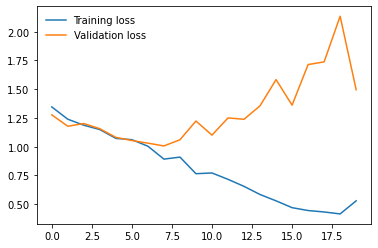

In [57]:
# visualise the training and validation losses over time
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend(frameon=False)

In [58]:
# Load the Model with the Lowest Validation Loss
model.load_state_dict(torch.load('CNN_model.pt'))

<All keys matched successfully>

###Test Accuracy Results

In [59]:
# Test the Trained Network

# initialize lists to monitor test loss and accuracy
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval() # prep model for evaluation

for data, target in test_loader:
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    # compare predictions to true label
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))
    # calculate test accuracy for each object class
    for i in range(len(target)):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# calculate and print avg test loss
test_loss = test_loss/len(test_loader.sampler)
print('Test Loss: {:.6f}\n'.format(test_loss))

# change value here to number of classes
for i in range(4):
    if class_total[i] > 0:
        if i == 0:
          print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
              "Great Whites     ", 100 * class_correct[i] / class_total[i],
              np.sum(class_correct[i]), np.sum(class_total[i])))
        if i == 1:
          print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
              "Leopard Sharks   ", 100 * class_correct[i] / class_total[i],
              np.sum(class_correct[i]), np.sum(class_total[i])))
        if i == 2:
          print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
              "Oceanic Whitetips", 100 * class_correct[i] / class_total[i],
              np.sum(class_correct[i]), np.sum(class_total[i])))
        if i == 3:
          print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
              "Whale Sharks     ", 100 * class_correct[i] / class_total[i],
              np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.952024

Test Accuracy of Great Whites     : 27% ( 5/18)
Test Accuracy of Leopard Sharks   : 86% (13/15)
Test Accuracy of Oceanic Whitetips: 64% (11/17)
Test Accuracy of Whale Sharks     : 85% (17/20)

Test Accuracy (Overall): 65% (46/70)


###Visualising The Test Results, Seeing How The Network Performed

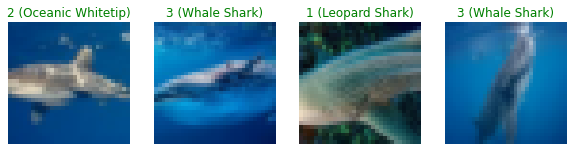

In [60]:
# Visualize Sample Test Results

# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds = torch.max(output, 1)

# plot the first 4 images in the batch, along with the corresponding labels
fig, axes = plt.subplots(figsize=(10,4), ncols=4)
for i in range(4):
    ax = axes[i]
    imshow(images[i], ax=ax, normalize=True)
    
    if labels[i].item() == 0:
          ax.set_title("{} ({})".format(str(preds[i].item()), shark_list[0]),
                    color=("green" if preds[i]==labels[i] else "red")) 
    if labels[i].item() == 1:
      ax.set_title("{} ({})".format(str(preds[i].item()), shark_list[1]),
                color=("green" if preds[i]==labels[i] else "red")) 
    if labels[i].item() == 2:
      ax.set_title("{} ({})".format(str(preds[i].item()), shark_list[2]),
                color=("green" if preds[i]==labels[i] else "red")) 
    if labels[i].item() == 3:
      ax.set_title("{} ({})".format(str(preds[i].item()), shark_list[3]),
                color=("green" if preds[i]==labels[i] else "red")) 

#Convolutional Neural Network WITH Data Augmentation and Transfer Learning (initially: 70%) (best: 90%)

###ResNet18 Architecture Setup

In [8]:
# load a pre-trained ResNet network with 18 layers
model = models.resnet18(pretrained=True)

# Using the following code freezes the pre-trained weights and only updates the final layer
# for param in model.parameters():
#     param.requires_grad = False

# get the number of inputs for the final layer (fc) of the network
num_ftrs = model.fc.in_features
# replace the final layer so that the output is number of classes
model.fc = nn.Linear(num_ftrs, 4)

# move tensors to GPU if CUDA is available
if train_on_gpu:
    model.cuda()

print(model)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

###Loss and Optimizer Initialisation

In [9]:
# specify loss function (cross entropy loss)
criterion = nn.CrossEntropyLoss()
# specify optimiser (Adam optimiser) and learning rate = 0.001
optimizer = optim.Adam(model.parameters(), lr=0.001)

###Training The Network

In [10]:
# number of epochs to train the model
n_epochs = 20

# initialise tracker for minimum validation loss
valid_loss_min = np.Inf # set initial "min" to infinity

# create empty lists to store the training and validation losses
train_losses, val_losses = [], []

for epoch in range(n_epochs):
    # monitor training loss
    train_loss = 0.0
    valid_loss = 0.0
    
    # training the model 
    model.train() # prep model for training
    for data, target in train_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item()*data.size(0)
          
    # validating the model 
    model.eval() # prep model for evaluation
    for data, target in val_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update running validation loss 
        valid_loss += loss.item()*data.size(0)
        
    # print training/validation statistics 
    # calculate average loss over an epoch
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(val_loader.sampler)

    # store the training and validation losses for later visualisation
    train_losses.append(train_loss)
    val_losses.append(valid_loss)
    
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch+1, 
        train_loss,
        valid_loss
        ))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'resnet18_model_fine_tune_aug.pt') # save in colab
        torch.save(model.state_dict(), '/content/gdrive/MyDrive/resnet18_model_fine_tune_aug.pt') # save in google drive
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 1.414749 	Validation Loss: 0.860831
Validation loss decreased (inf --> 0.860831).  Saving model ...
Epoch: 2 	Training Loss: 1.058890 	Validation Loss: 0.943017
Epoch: 3 	Training Loss: 1.037193 	Validation Loss: 0.802583
Validation loss decreased (0.860831 --> 0.802583).  Saving model ...
Epoch: 4 	Training Loss: 1.004627 	Validation Loss: 0.955476
Epoch: 5 	Training Loss: 0.952527 	Validation Loss: 0.612604
Validation loss decreased (0.802583 --> 0.612604).  Saving model ...
Epoch: 6 	Training Loss: 0.849370 	Validation Loss: 0.653661
Epoch: 7 	Training Loss: 0.758169 	Validation Loss: 0.947771
Epoch: 8 	Training Loss: 0.823266 	Validation Loss: 0.556774
Validation loss decreased (0.612604 --> 0.556774).  Saving model ...
Epoch: 9 	Training Loss: 0.754733 	Validation Loss: 0.713260
Epoch: 10 	Training Loss: 0.749363 	Validation Loss: 0.574592
Epoch: 11 	Training Loss: 0.695305 	Validation Loss: 0.958325
Epoch: 12 	Training Loss: 0.727637 	Validation Loss: 0.6

###Plotting The Training and Validation Losses To a Graph

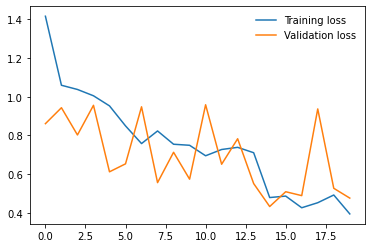

In [11]:
# training and validation losses over time
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend(frameon=False)

In [12]:
# Load the Model with the Lowest Validation Loss
model.load_state_dict(torch.load('resnet18_model_fine_tune_aug.pt'))

<All keys matched successfully>

###Test Accuracy Results

In [13]:
# Test the Trained Network

# initialize lists to monitor test loss and accuracy
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
num_of_classes = 4

model.eval() # prep model for evaluation

for data, target in test_loader:
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    # compare predictions to true label
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))
    # calculate test accuracy for each object class
    for i in range(len(target)):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# calculate and print avg test loss
test_loss = test_loss/len(test_loader.sampler)
print('Test Loss: {:.6f}\n'.format(test_loss))

# change value here to number of classes
for i in range(num_of_classes):
    if class_total[i] > 0:
      if i == 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            "Great Whites     ", 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
      if i == 1:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            "Leopard Sharks   ", 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
      if i == 2:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            "Oceanic Whitetips", 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
      if i == 3:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            "Whale Sharks     ", 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.342350

Test Accuracy of Great Whites     : 83% (15/18)
Test Accuracy of Leopard Sharks   : 100% (15/15)
Test Accuracy of Oceanic Whitetips: 88% (15/17)
Test Accuracy of Whale Sharks     : 90% (18/20)

Test Accuracy (Overall): 90% (63/70)


###Visualising How Well The Network Performed

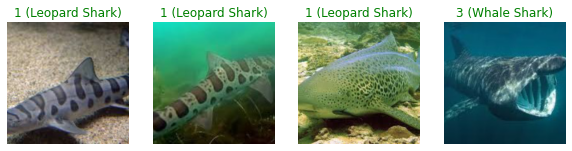

In [14]:
# Visualize Sample Test Results

# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()
images.numpy()

# move model inputs to cuda, if GPU available
if train_on_gpu:
    images = images.cuda()

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())

# plot the first 4 images in the batch, along with the corresponding labels
fig, axes = plt.subplots(figsize=(10,4), ncols=4)
for i in range(4):
    ax = axes[i]
    imshow(images.cpu()[i], ax=ax, normalize=True)

    if(labels[i].item() == 0):
      ax.set_title("{} ({})".format(str(preds[i].item()), shark_list[0]),
                   color=("green" if preds[i]==labels[i] else "red")) 
    if(labels[i].item() == 1):
      ax.set_title("{} ({})".format(str(preds[i].item()), shark_list[1]),
                   color=("green" if preds[i]==labels[i] else "red")) 
    if(labels[i].item() == 2):
      ax.set_title("{} ({})".format(str(preds[i].item()), shark_list[2]),
                   color=("green" if preds[i]==labels[i] else "red")) 
    if(labels[i].item() == 3):
      ax.set_title("{} ({})".format(str(preds[i].item()), shark_list[3]),
                   color=("green" if preds[i]==labels[i] else "red")) 

#Visualising class features with t-SNE

###Define Transforms and Prepare Test Dataloader

In [19]:
data_dir = 'shark_dataset_v3/shark_dataset'
batch_size = 100

# define transforms
transform = transforms.Compose([transforms.Resize(224), 
                                transforms.CenterCrop(224),
                                transforms.ToTensor(),
                                transforms.Normalize([0.485, 0.456, 0.406],
                                                     [0.229, 0.224, 0.225])]) 

# define the test dataset
test_data = datasets.ImageFolder(data_dir + '/test', transform=transform)

# data loader preparation
test_loader = torch.utils.data.DataLoader(test_data, batch_size, shuffle=True)

###Loading The Pre-trained Model (ResNet18)

In [20]:
# for t-SNE we will use a trained network to extract features for each image
# we will remove the final layer of the network so the output a 512 feature vector

# load model
import torch.nn as nn
import torchvision.models as models
from torch.autograd import Variable

# load a pre-trained ResNet network with 18 layers
model = models.resnet18(pretrained=True)
# # remove the final layer so the output of the network is now a 512 feature vector
model = nn.Sequential(*list(model.children())[:-1])

# move tensors to GPU if CUDA is available
if train_on_gpu:
    model.cuda()

print(model)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

In [21]:
# Load previously trained model

# create a new model with ResNet18 architecture
myModel = models.resnet18(pretrained=True)
# get the number of inputs for the final layer (fc) of the network
num_ftrs = myModel.fc.in_features
# replace the final layer so that the output is four classes
myModel.fc = nn.Linear(num_ftrs, 4)
# load previously trained model
myModel.load_state_dict(torch.load('/content/gdrive/MyDrive/resnet18_model_fine_tune_aug.pt'))
# remove the final layer so the output of the network is now a 512 feature vector
myModel = nn.Sequential(*list(myModel.children())[:-1])

# move tensors to GPU if CUDA is available
if train_on_gpu:
    myModel.cuda()

# print(myModel)

###Feature Results

In [22]:
# Visualize Sample Test Results

# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()

# move model inputs to cuda, if GPU available
if train_on_gpu:
    images = images.cuda()

# get sample outputs
imageNet_feats = model(images)
sharks_feats = myModel(images)

# put on cpu, convert to numpy array and squeeze to batchsize x 512
imageNet_feats = np.squeeze(imageNet_feats.cpu().detach().numpy())
sharks_feats = np.squeeze(sharks_feats.cpu().detach().numpy())

labels = labels.numpy()

print(imageNet_feats.shape)
print(sharks_feats.shape)
print(labels)

(70, 512)
(70, 512)
[2 2 1 3 0 1 3 3 0 0 0 2 2 2 1 2 3 1 2 3 0 2 1 3 1 3 2 3 2 0 3 3 3 3 3 2 1
 3 2 0 2 1 0 0 0 3 3 3 1 3 0 2 3 1 0 0 1 0 0 1 2 1 1 2 2 0 1 0 3 0]


###Plotting The Results Onto a Graph

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


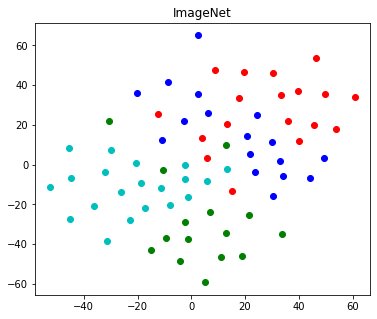

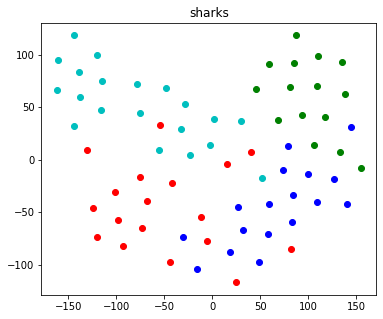

In [23]:
############################################################
# Fit and transform with a TSNE
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=0) 

############################################################
# Project the data in 2D
imageNet_X_2d = tsne.fit_transform(imageNet_feats)
sharks_X_2d = tsne.fit_transform(sharks_feats)

############################################################
# Visualize the data
plt.figure(figsize=(6, 5))
for i in range(imageNet_X_2d.shape[0]):
  if labels[i] == 0:
    # 0 Great White Shark
    plt.scatter(imageNet_X_2d[i,0], imageNet_X_2d[i, 1], c='r')
  if labels[i] == 1:
    # 1 Leopard Shark
    plt.scatter(imageNet_X_2d[i,0], imageNet_X_2d[i, 1], c='g')
  if labels[i] == 2:
    # 2 Oceanic Whitetip Shark
    plt.scatter(imageNet_X_2d[i,0], imageNet_X_2d[i, 1], c='b')
  if labels[i] == 3:
    # 3 Whale Shark
    plt.scatter(imageNet_X_2d[i,0], imageNet_X_2d[i, 1], c='c')
plt.title('ImageNet')
# plt.show()

# Visualize the data
plt.figure(figsize=(6, 5))
for i in range(sharks_X_2d.shape[0]):
  if labels[i] == 0:
    # 0 Great White Shark
    plt.scatter(sharks_X_2d[i,0], sharks_X_2d[i, 1], c='r')
  if labels[i] == 1:
    # 1 Leopard Shark
    plt.scatter(sharks_X_2d[i,0], sharks_X_2d[i, 1], c='g')
  if labels[i] == 2:
    # 2  Oceanic Whitetip Shark
    plt.scatter(sharks_X_2d[i,0], sharks_X_2d[i, 1], c='b')
  if labels[i] == 3:
    # 3 Whale Shark
    plt.scatter(sharks_X_2d[i,0], sharks_X_2d[i, 1], c='c')
plt.title('sharks')
# plt.show()
plt.show()

<font color='red'>**RED**</font>: Great White, <font color='green'>**GREEN**</font>: Leopard, <font color='blue'>**BLUE**</font>: Oceanic Whitetip, <font color='cyan'>**CYAN**</font>: Whale  

# Visualising How The Network Identifies Features With Class Activation Maps (SmoothGradCAM++) 

###Cloning the SmoothGradCAM repository 

In [24]:
!git clone https://github.com/yiskw713/SmoothGradCAMplusplus.git

Cloning into 'SmoothGradCAMplusplus'...
remote: Enumerating objects: 47, done.
remote: Counting objects: 100% (27/27), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 47 (delta 13), reused 24 (delta 11), pack-reused 20
Unpacking objects: 100% (47/47), done.


In [25]:
%cd /content/SmoothGradCAMplusplus/

/content/SmoothGradCAMplusplus


In [26]:
import numpy as np
import skimage.transform
import torch
import torch.nn as nn
import torch.nn. functional as F

from PIL import Image
from matplotlib.pyplot import imshow
from torchvision import models, transforms
from torchvision.utils import save_image

from cam import CAM, GradCAM, GradCAMpp, SmoothGradCAMpp
from utils.visualize import visualize, reverse_normalize
from utils.imagenet_labels import label2idx, idx2label

###Preprocessing Transforms

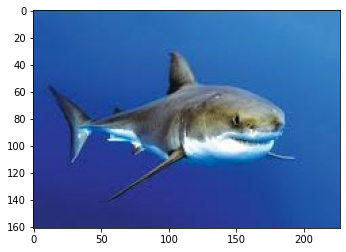

In [33]:
image = Image.open('/content/shark_dataset_v3/shark_dataset/train/great_white/great_white (18).jpg') # Great White 
#image = Image.open('/content/SmoothGradCAMplusplus/shark_dataset_v3/shark_dataset/train/leopard/leopard (5).jpg')           # Leopard shark
#image = Image.open('/content/shark_dataset_v3/shark_dataset/train/oceanic_whitetip/oceanic_whitetip (17).jpg')           # Oceanic Whitetip 
#image = Image.open('/content/SmoothGradCAMplusplus/shark_dataset_v3/shark_dataset/train/whale/whale (79).jpg')           # Whale shark

imshow(image)

In [34]:
# preprocessing. mean and std from ImageNet
normalize = transforms.Normalize(
   mean=[0.485, 0.456, 0.406],
   std=[0.229, 0.224, 0.225]
)

preprocess = transforms.Compose([
    transforms.ToTensor(),
    normalize
])

# convert image to tensor
tensor = preprocess(image)

# reshape 4D tensor (N, C, H, W)
tensor = tensor.unsqueeze(0)

###Evaluating The Model

In [35]:
model = models.resnet18(pretrained=True)
model.eval()
# print(model)

# the target layer you want to visualize
target_layer = model.layer4[1].conv2

# wrapper for class activation mapping. Choose one of the following.
#wrapped_model = CAM(model, target_layer)
#wrapped_model = GradCAM(model, target_layer)
#wrapped_model = GradCAMpp(model, target_layer)
wrapped_model = SmoothGradCAMpp(model, target_layer, n_samples=25, stdev_spread=0.15)

cam, idx = wrapped_model(tensor)
print(idx2label[idx])

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:1025: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


predicted class ids 2	 probability 0.9324156641960144
great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias


###Visualising The Cam Heatmap

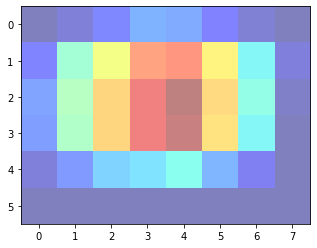

In [36]:
# visualize only cam
imshow(cam.squeeze().numpy(), alpha=0.5, cmap='jet')

###Visualising The Shark Heatmap

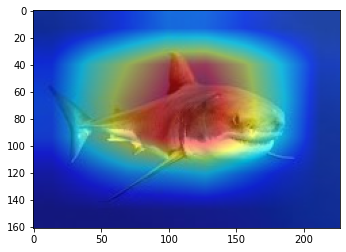

In [37]:
# reverse normalization for display
img = reverse_normalize(tensor)

heatmap = visualize(img, cam)

# save image
# save_image(heatmap, './sample/{}_cam.png'.format(idx2label[idx]).replace(" ", "_").replace(",", ""))
# save_image(heatmap, './sample/{}_gradcam.png'.format(idx2label[idx]).replace(" ", "_").replace(",", ""))
# save_image(heatmap, './sample/{}_gradcampp.png'.format(idx2label[idx]).replace(" ", "_").replace(",", ""))
save_image(heatmap, './sample/{}_smoothgradcampp.png'.format(idx2label[idx]).replace(" ", "_").replace(",", ""))

# or visualize on Jupyter
hm = (heatmap.squeeze().numpy().transpose(1, 2, 0))
imshow(hm)